<a href="https://colab.research.google.com/github/SaraMohamed-121/CV-ST-24/blob/main/notebook5888ca8c77.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'appl-ai-cv-st-24-assignment-1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F83802%2F9339243%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240817%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240817T175439Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D97d4fcc2c1eed545a0b08a5cfd47d778cae1c2faaa6830640d5173a8bc096db6a30e7b30b4ee520b8371e8fa7d56a3af17e9811bd345fe22ea512754818867f660215430a95bc166ed0a2116fce1b22fa5b4e02672a63388e5d9271bf8261dfac13e2d09a8e6182630e367f9b93faebe2d06bd0cfba40fdba65558ad0f7368652e46d507666997900381df53f430aa71935ddd6ba1572167fb75aadb10dc405f92ef00bcda6ad25f209229552968b4ffb2a42139d477cb33e80be9467a1796c9fb5ea9f49f4eabf723ac967a6888a7c72ef62c954d70f198219909a9ddb0d79457ef98530fd8ca711ed7f8fabf536bcae85b6ed0c539ee93bc22a069bf31a658'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2819510 bytes downloaded
Downloaded and uncompressed: appl-ai-cv-st-24-assignment-1
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import joblib

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# Load data
train_path = '/kaggle/input/appl-ai-cv-st-24-assignment-1/train.csv'
valid_path = '/kaggle/input/appl-ai-cv-st-24-assignment-1/test.csv'
traindata = pd.read_csv(train_path)
valldata = pd.read_csv(valid_path)
print(f'train data: {traindata.shape}\nval data: {valldata.shape}')
traindata.info()

train data: (103904, 25)
val data: (25976, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64

In [3]:
#dataset contains 103904 examples and 25 columns, 24 features
from sklearn.model_selection import train_test_split
traindata, testdata = train_test_split(traindata, test_size=0.3, random_state=42)
traindata.head(5)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
17901,17901,67857,Female,Loyal Customer,35,Personal Travel,Eco,1235,1,4,...,4,4,4,4,5,5,4,0,19.0,neutral or dissatisfied
49209,49209,75897,Male,Loyal Customer,56,Business travel,Business,603,5,5,...,5,5,5,5,5,5,3,89,86.0,satisfied
32340,32340,74965,Female,Loyal Customer,45,Personal Travel,Eco,2586,2,2,...,1,1,2,1,2,1,3,0,0.0,neutral or dissatisfied
50831,50831,63686,Male,Loyal Customer,47,Business travel,Business,2422,2,2,...,4,4,4,4,4,4,3,0,0.0,satisfied
10989,10989,101324,Male,Loyal Customer,40,Personal Travel,Eco,1076,2,4,...,4,5,3,5,4,4,4,18,18.0,neutral or dissatisfied


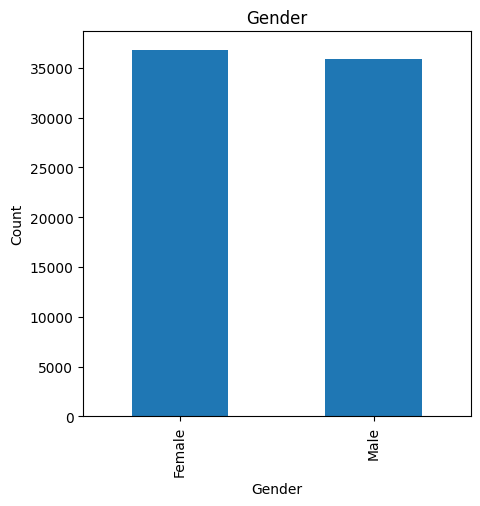

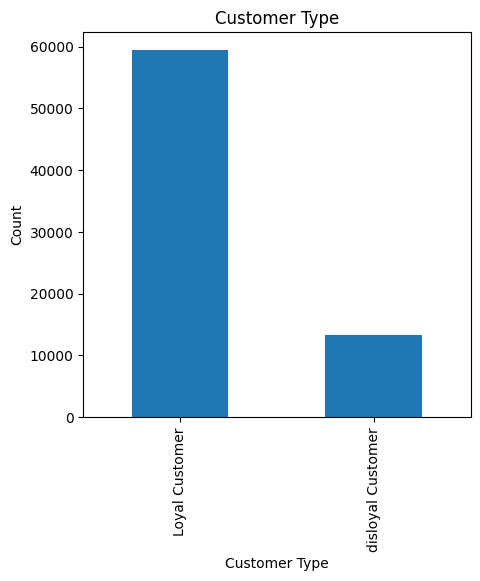

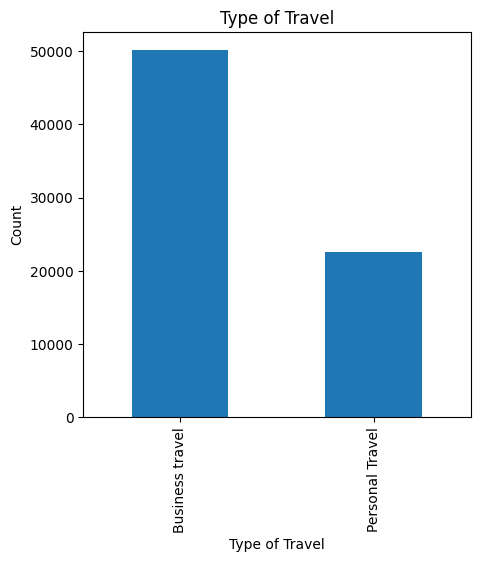

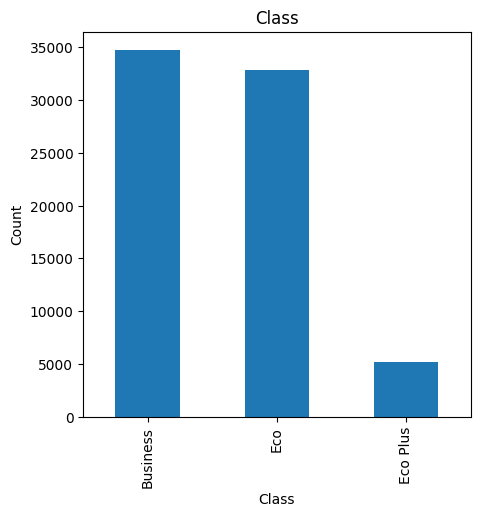

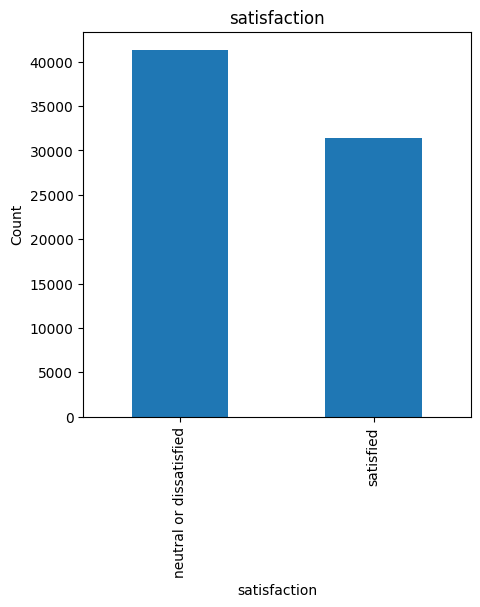

17901     neutral or dissatisfied
49209                   satisfied
32340     neutral or dissatisfied
50831                   satisfied
10989     neutral or dissatisfied
                   ...           
54886     neutral or dissatisfied
76820     neutral or dissatisfied
103694    neutral or dissatisfied
860                     satisfied
15795     neutral or dissatisfied
Name: satisfaction, Length: 72732, dtype: object


In [4]:
for col in traindata.columns:
    if traindata[col].dtype == 'object':
        #print(col)
        traindata[col].value_counts().plot(kind='bar', figsize=(5,5))
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()
print(traindata['satisfaction'])
# traindata['Gender'].value_counts().plot(kind='bar', figsize=(5,5))
# traindata['Customer Type'].value_counts().plot(kind='bar', figsize=(5,5))
# traindata['Type of Travel'].value_counts().plot(kind='bar', figsize=(5,5))
# traindata['Class'].value_counts().plot(kind='bar', figsize=(5,5))
# traindata['satisfaction'].value_counts().plot(kind='bar', figsize=(5,5))

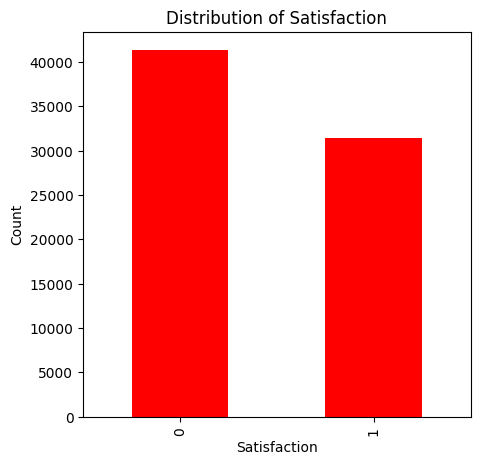

In [5]:
satisfaction_mapping = {'satisfied': 1, 'neutral or dissatisfied': 0}
traindata['satisfaction'] = traindata['satisfaction'].map(satisfaction_mapping)
testdata['satisfaction'] = testdata['satisfaction'].map(satisfaction_mapping)
# prediction train data
if not traindata['satisfaction'].empty:
    traindata['satisfaction'].value_counts().plot(kind='bar', figsize=(5, 5), color='red')
    plt.xlabel('Satisfaction')
    plt.ylabel('Count')
    plt.title('Distribution of Satisfaction')
    plt.show()
else:
    print("No data to plot.")

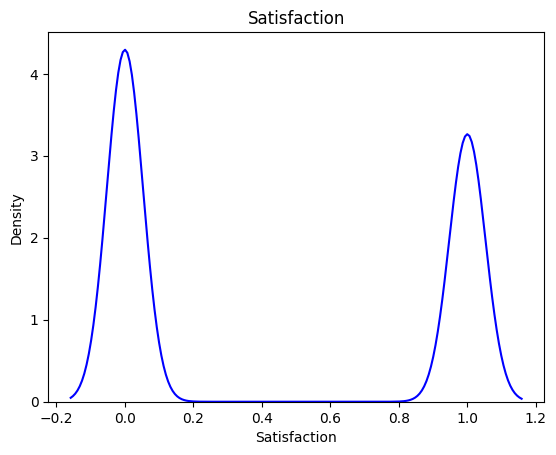

0.2752479907599333


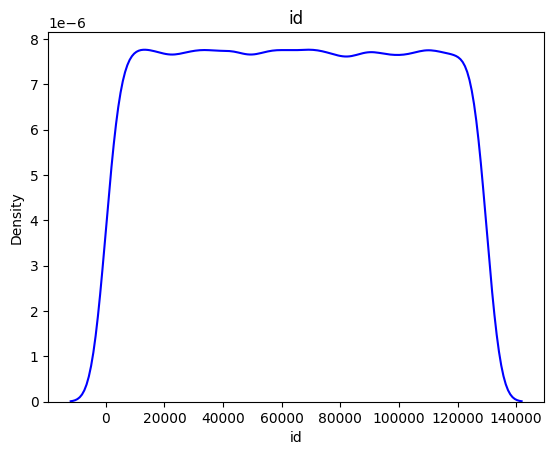

In [6]:
sns.kdeplot(data=traindata, x='satisfaction', color='blue')
plt.xlabel('Satisfaction')
plt.title('Satisfaction')
plt.show()
skewness = traindata['satisfaction'].skew()
print(skewness)

sns.kdeplot(data=traindata, x='id', color='blue')
plt.xlabel('id')
plt.title('id')
plt.show()

In [7]:
def get_feats_and_labels(data, label):
    data_feats = data.drop(label, axis=1)
    data_label = data[label]
    return data_feats, data_label

train_feats, train_label = get_feats_and_labels(traindata, 'satisfaction')
train_feats
train_label

,satisfaction
17901,0
49209,1
32340,0
50831,1
10989,0
...,...
54886,0
76820,0
103694,0
860,1


In [8]:
traindata = traindata.drop(['Unnamed: 0', 'Gender' ,'id' , 'Age'], axis=1)
traindata.head(5)

,Customer Type,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
17901,Loyal Customer,Personal Travel,Eco,1235,1,4,1,3,4,1,...,4,4,4,4,5,5,4,0,19.0,0
49209,Loyal Customer,Business travel,Business,603,5,5,5,5,4,4,...,5,5,5,5,5,5,3,89,86.0,1
32340,Loyal Customer,Personal Travel,Eco,2586,2,2,2,3,3,3,...,1,1,2,1,2,1,3,0,0.0,0
50831,Loyal Customer,Business travel,Business,2422,2,2,2,2,2,5,...,4,4,4,4,4,4,3,0,0.0,1
10989,Loyal Customer,Personal Travel,Eco,1076,2,4,2,3,4,2,...,4,5,3,5,4,4,4,18,18.0,0


In [9]:
scaler = StandardScaler()
encoder = OrdinalEncoder()


# The column transformer requires lists of features
num_feats = ['Age', 'Flight Distance', 'Inflight wifi service',
             'Departure/Arrival time convenient', 'Ease of Online booking',
             'Gate location', 'Food and drink', 'Online boarding',
             'Seat comfort', 'Inflight entertainment', 'On-board service',
             'Leg room service', 'Baggage handling', 'Checkin service',
             'Inflight service', 'Cleanliness', 'Departure Delay in Minutes',
             'Arrival Delay in Minutes']

cat_feats = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

# define the pipeline to scale the numeric features and handle categorical features
final_pipe = ColumnTransformer([
   ('num',scaler , num_feats),
   ('cat', encoder , cat_feats)

])
training_data_prepared = final_pipe.fit_transform(train_feats)
print(training_data_prepared.shape)
type(training_data_prepared)


(72732, 22)


numpy.ndarray

In [10]:
test_feats, test_label = get_feats_and_labels(testdata, 'satisfaction')
test_feats
test_label

,satisfaction
80638,0
43398,0
32751,0
33571,0
71287,0
...,...
5007,1
4869,1
93969,0
78320,1


In [11]:
test_data_prepared = final_pipe.transform(test_feats)
test_data_prepared

array([[-0.88159849, -0.32922833, -0.54805418, ...,  0.        ,
         1.        ,  1.        ],
       [-1.14623221, -0.79855231,  0.20549183, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.30162976, -0.99610963, -1.3016002 , ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 1.10315446, -0.01734851, -0.54805418, ...,  0.        ,
         1.        ,  1.        ],
       [-0.68312319,  1.63330806,  0.20549183, ...,  0.        ,
         0.        ,  0.        ],
       [-1.01391535, -0.70729487,  1.71258385, ...,  1.        ,
         0.        ,  1.        ]])

In [12]:
# train_label = train_label.to_numpy()
# test_label = test_label.to_numpy()
# Check if train_label is already a numpy array
if isinstance(train_label, np.ndarray):
    # No need to convert, just assign
    train_label = train_label
else:
    # Convert to numpy array if it's a DataFrame or Series
    train_label = train_label.to_numpy()

# Repeat for test_label
if isinstance(test_label, np.ndarray):
    test_label = test_label
else:
    test_label = test_label.to_numpy()


train_label
test_label

array([0, 0, 0, ..., 0, 1, 1])

In [13]:
input_shape = training_data_prepared.shape[1:]
input_shape

(22,)

In [14]:
model = keras.models.Sequential([

            # The first layers must specify the input shape always
            keras.layers.Dense(24, activation='relu', input_shape=input_shape),
            keras.layers.Dense(48, activation='relu'),
            keras.layers.Dense(96, activation='relu'),
            keras.layers.Dense(192, activation='relu'),
            # The last layer usually doesn't have activation function in regression
            keras.layers.Dense(1)

])

# Now we compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 24)                  │             552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 48)                  │           1,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 96)                  │           4,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 192)                 │          18,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,273 (98.72 KB)

 Trainable params: 25,273 (98.72 KB)

 Non-trainable params: 0 (0.00 B)

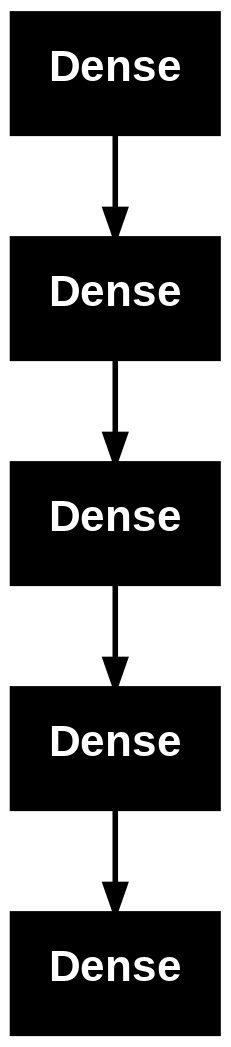

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [16]:
import numpy as np

# Convert labels to float64
train_label = train_label.astype('float64')
test_label = test_label.astype('float64')

# Print data types to confirm
print("training_data_prepared dtype:", training_data_prepared.dtype)
print("train_label dtype:", train_label.dtype)
print("test_data_prepared dtype:", test_data_prepared.dtype)
print("test_label dtype:", test_label.dtype)

# Handle NaN values in numpy arrays
if np.isnan(training_data_prepared).any():
    print("Data contains NaN values in training_data_prepared. Cleaning the data...")
    training_data_prepared = np.where(np.isnan(training_data_prepared),
                                      np.nanmean(training_data_prepared, axis=0),
                                      training_data_prepared)

if np.isnan(test_data_prepared).any():
    print("Data contains NaN values in test_data_prepared. Cleaning the data...")
    test_data_prepared = np.where(np.isnan(test_data_prepared),
                                  np.nanmean(test_data_prepared, axis=0),
                                  test_data_prepared)

# Verify that the NaN values are handled
if np.isnan(training_data_prepared).any():
    print("NaN values still exist in training data.")
else:
    print("Training data is clean.")

if np.isnan(test_data_prepared).any():
    print("NaN values still exist in test data.")
else:
    print("Test data is clean.")

training_data_prepared dtype: float64
train_label dtype: float64
test_data_prepared dtype: float64
test_label dtype: float64
Data contains NaN values in training_data_prepared. Cleaning the data...
Data contains NaN values in test_data_prepared. Cleaning the data...
Training data is clean.
Test data is clean.


In [17]:
# Fit the model again
history = model.fit(training_data_prepared, train_label,
                    validation_data=(test_data_prepared, test_label),
                    epochs=150)

Epoch 1/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0935 - val_loss: 0.0469
Epoch 2/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0430 - val_loss: 0.0377
Epoch 3/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0366 - val_loss: 0.0355
Epoch 4/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0332 - val_loss: 0.0350
Epoch 5/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0310 - val_loss: 0.0327
Epoch 6/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0303 - val_loss: 0.0323
Epoch 7/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0295 - val_loss: 0.0326
Epoch 8/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0294 - val_loss: 0.0313
Epoch 9/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0283 - val_loss: 0.0314
Epoch 10/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0279 - val_loss: 0.0307
Epoch 11/100
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0278 - val_loss: 0.0307
Epoch 12/10

<Axes: >

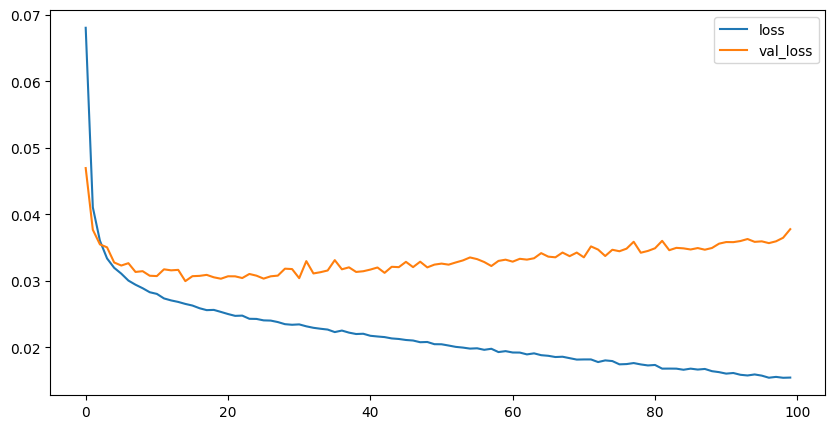

In [18]:
loss_df = pd.DataFrame(history.history)
loss_df.plot(figsize=(10,5))

In [19]:
model.evaluate(test_data_prepared, test_label)

975/975 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0375


0.03774425759911537

<Axes: xlabel='satisfaction', ylabel='Density'>

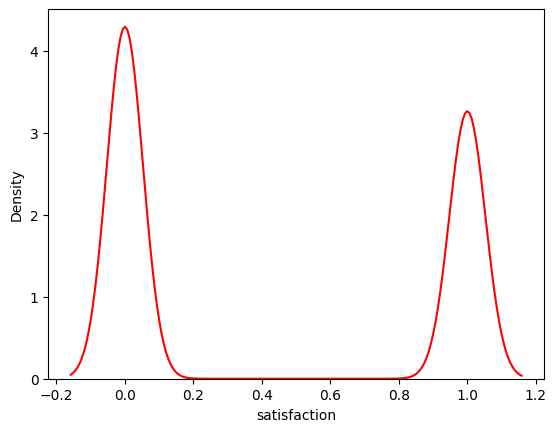

In [20]:
sns.kdeplot(data=traindata, x='satisfaction', color='red')

In [31]:
model_2 = keras.models.Sequential([

            # The first layers must specify the input shape always
            keras.layers.Dense(12, activation='relu', input_shape=input_shape),
            keras.layers.Dense(24, activation='relu'),
            keras.layers.Dense(6, activation='relu'),
            keras.layers.Dense(3, activation='relu'),
            # The last layer usually doesn't have activation function in regression
            keras.layers.Dense(1, activation='sigmoid')

])

# Now we compile the model
model_2.compile(loss='log_cosh', optimizer='adam')
history = model_2.fit(training_data_prepared, train_label,
                    validation_data = (test_data_prepared, test_label), epochs=150)

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2273/2273 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0728 - val_loss: 0.0306
Epoch 2/150
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0281 - val_loss: 0.0238
Epoch 3/150
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0226 - val_loss: 0.0215
Epoch 4/150
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0208 - val_loss: 0.0197
Epoch 5/150
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0193 - val_loss: 0.0187
Epoch 6/150
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0183 - val_loss: 0.0189
Epoch 7/150
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0179 - val_loss: 0.0182
Epoch 8/150
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0175 - val_loss: 0.0176
Epoch 9/150
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0171 - val_loss: 0.0179
Epoch 10/150
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0168 - val_loss: 0.0171
Epoch 11/150
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 12/150
2273/2273 ━━━━━━━

<Axes: >

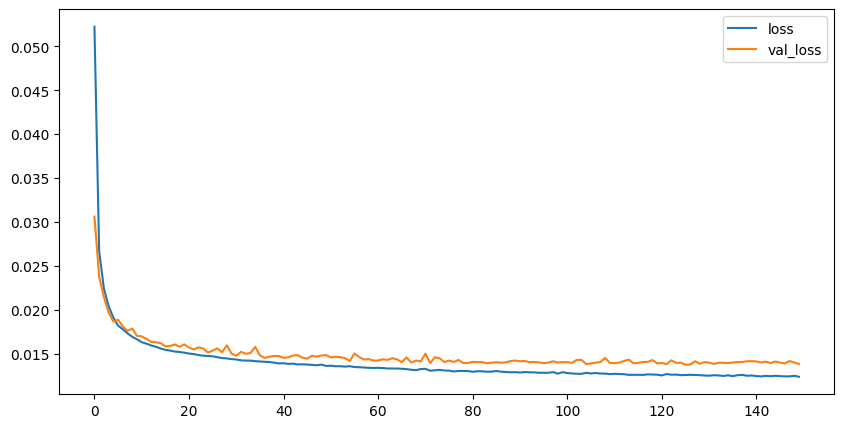

In [32]:
loss_df = pd.DataFrame(history.history)
loss_df.plot(figsize=(10,5))

In [34]:
model.evaluate(test_data_prepared, test_label)

AttributeError: 'RandomForestClassifier' object has no attribute 'evaluate'

In [35]:
model.save('f_model.h5')
print("done")

AttributeError: 'RandomForestClassifier' object has no attribute 'save'

<Axes: >

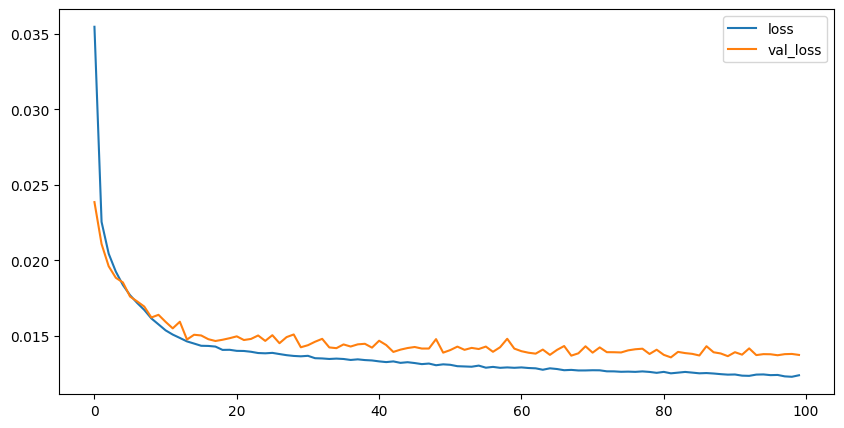

In [25]:
loaded_model = keras.models.load_model('f_model.h5')
loss_acc_metrics_df = pd.DataFrame(history.history)
loss_acc_metrics_df.plot(figsize=(10,5))

In [26]:
# Evaluate the model
model_eval = model_2.evaluate(test_data_prepared, test_label)

# Check if the evaluation returned a single value or multiple values
if isinstance(model_eval, float):
    print(f"Test loss: {model_eval}")
else:
    # If the evaluation returns a list/tuple, assuming [loss, accuracy]
    print(f"Test loss: {model_eval[0]}\nTest accuracy: {model_eval[1]}")

975/975 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0136
Test loss: 0.013744691386818886


In [27]:
# Define a function to extract features (dropping the target column if present)
def get_feats(data):
    return data.drop(['Unnamed: 0', 'satisfaction'], axis=1, errors='ignore')

# Define the numeric and categorical features (ensure these match your data)
num_feats = ['Age', 'Flight Distance', 'Inflight wifi service',
             'Departure/Arrival time convenient', 'Ease of Online booking',
             'Gate location', 'Food and drink', 'Online boarding',
             'Seat comfort', 'Inflight entertainment', 'On-board service',
             'Leg room service', 'Baggage handling', 'Checkin service',
             'Inflight service', 'Cleanliness', 'Departure Delay in Minutes',
             'Arrival Delay in Minutes']

cat_feats = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

# Define the pipeline to handle missing values, scale numeric features, and encode categorical features
final_pipe = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values in numeric features
        ('scaler', StandardScaler())
    ]), num_feats),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values in categorical features
        ('encoder', OneHotEncoder())
    ]), cat_feats)
])

train_target = traindata['satisfaction']

# Fit the pipeline on the training data features
final_pipe.fit(train_feats)

# Transform training features using the fitted pipeline
train_feats_prepared = final_pipe.transform(train_feats)

# Train your model (example using RandomForestClassifier)
model = RandomForestClassifier()
model.fit(train_feats_prepared, train_target)

# Save the pipeline and model
joblib.dump(final_pipe, 'final_pipe.pkl')
joblib.dump(model, 'your_model.pkl')


# Get the features from the validation data
val_feats = get_feats(valldata)

# Prepare the validation data using the already fitted pipeline
val_data_prepared = final_pipe.transform(val_feats)

# Load your previously saved model
loaded_model = joblib.load('your_model.pkl')

# Make predictions on validation data
predictions = loaded_model.predict(val_data_prepared)
print(predictions[:15])



[1 1 0 1 0 1 1 1 1 1 1 0 1 1 1]


In [30]:
# If predictions is a numpy array of strings, convert it using the mapping
predictions_mapped = np.array([satisfaction_mapping.get(pred, pred) for pred in predictions])

#ids = np.arange(0, 25976)
ids = valldata['id']
# Create a DataFrame with 'id' and 'y' (predictions)
output_df = pd.DataFrame({
    'ID': ids,
    'y': predictions_mapped
})
print(output_df)
print(predictions_mapped.shape)
# Save the DataFrame to a CSV file
output_df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

          ID  y
0      19556  1
1      90035  1
2      12360  0
3      77959  1
4      36875  0
...      ... ..
25971  78463  0
25972  71167  1
25973  37675  0
25974  90086  1
25975  34799  0

[25976 rows x 2 columns]
(25976,)
Predictions saved to 'predictions.csv'
